How does `WARC-Identified-Content-Language` (cld2) differ from fasttext `lid.176.bin`?

```bash
# Download 1 shard and extract WARC-Identified-Content-Language into "languages" field
python -m cc_net.process_wet_file dl --dump 2023-50 --num_shards 2000 --shard 0 --output data/raw/2023-50/0000.jsonl

# Run fasttext and get top 10 highest probability languages
python -m cc_net.split_by_lang -f data/raw/2023-50/0000.jsonl --model bin/lid.bin --field raw_content --out_field fasttext_languages --top 10 --output data/lang_exp/top_10.json
```

In [7]:
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [15]:
# For each of the nordic languages, plot precision/recall curve, i.e. how well does FT align with cld2 labels?
cld2_labels = []
fasttext_scores = []
texts = []

with open("../data/lang_exp/top_10.json") as f:
    for line in tqdm(f):
        parsed = json.loads(line)
        texts.append(parsed["raw_content"])
        cld2_labels.append(set(parsed["languages"]))
        fasttext_scores.append(parsed["fasttext_languages"])

1563389it [01:51, 14057.07it/s]


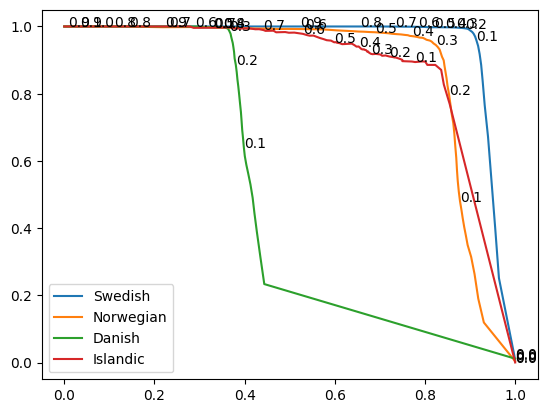

In [14]:
sv_precision, sv_recall, sv_thresholds = precision_recall_curve(
    y_true=[1 if "swe" in cld2_labels[i] else 0 for i in range(len(cld2_labels))],
    probas_pred=[fasttext_scores[i].get("sv", 0.0) for i in range(len(cld2_labels))]
)

da_precision, da_recall, da_thresholds = precision_recall_curve(
    y_true=[1 if "dan" in cld2_labels[i] else 0 for i in range(len(cld2_labels))],
    probas_pred=[fasttext_scores[i].get("da", 0.0) for i in range(len(cld2_labels))]
)

is_precision, is_recall, is_thresholds = precision_recall_curve(
    y_true=[1 if "isl" in cld2_labels[i] else 0 for i in range(len(cld2_labels))],
    probas_pred=[fasttext_scores[i].get("is", 0.0) for i in range(len(cld2_labels))]
)

no_precision, no_recall, no_thresholds = precision_recall_curve(
    y_true=[1 if "nor" in cld2_labels[i] else 0 for i in range(len(cld2_labels))],
    probas_pred=[fasttext_scores[i].get("no", 0.0) for i in range(len(cld2_labels))]
)

plt.plot(sv_recall, sv_precision, label="Swedish")
plt.plot(no_recall, no_precision, label="Norwegian")
plt.plot(da_recall, da_precision, label="Danish")
plt.plot(is_recall, is_precision, label="Islandic")

for p, r, t in zip(sv_precision[::10], sv_recall[::10], sv_thresholds[::10]):
    plt.annotate(f"{t:0.1f}", (r, p))

for p, r, t in zip(no_precision[::10], no_recall[::10], no_thresholds[::10]):
    plt.annotate(f"{t:0.1f}", (r, p))

for p, r, t in zip(da_precision[::10], da_recall[::10], da_thresholds[::10]):
    plt.annotate(f"{t:0.1f}", (r, p))

for p, r, t in zip(is_precision[::10], is_recall[::10], is_thresholds[::10]):
    plt.annotate(f"{t:0.1f}", (r, p))

plt.legend()

Danish looks interesting, maybe the cld2 performance of danish is bad? Let's look at FN at t=0.2 

In [20]:
i = 0

In [61]:
while i < len(cld2_labels):
    if "dan" in cld2_labels[i] and fasttext_scores[i].get("da", 0.0) < 0.2:
        print(i, cld2_labels[i], fasttext_scores[i].get("da", 0.0), fasttext_scores[i])
        print(texts[i])
        i += 1
        break
    else:
        i += 1

2810 {'zho', 'dan'} 0.0 {'zh': 0.9, 'ja': 0.06, 'en': 0.01, 'ko': 0.0, 'el': 0.0, 'fr': 0.0, 'ta': 0.0, 'sr': 0.0, 'kn': 0.0, 'ml': 0.0}
Óòµ
È¶ñÈ†Å
Èóú‰∫éÊàëÂÄë
Áî¢ÂìÅÂ±ïÁ§∫
Êñ∞ËÅû‰∏≠ÂøÉ
ËÅØÁ≥ªÊàëÂÄë
Â∞àÊ•≠Á∑öÊùüÂà∂ÈÄ†
ÊîØÊåÅÂÆöÂà∂ÂêÑÁ®ÆË¶èÊ†ºÈõªÂ≠êÁ∑ö „ÄÅÁ´ØÂ≠êÁ∑ö „ÄÅÊéíÁ∑ö „ÄÅÈÄ£Êé•Á∑ö „ÄÅÁ∑öÊùêÂë®ÈÇäÁ≠â
PRODUCT SHOW
Áî¢ÂìÅ‰∏≠ÂøÉ
Áî¢ÂìÅÂàÜÈ°û
ÂÖ®ÈÉ®ÂàÜÈ°ûÓöØ
ÓöØ
{{else}} {{= name}} {{/if}} {{if parent}} {{else}} {{/if}}
Óö∞
ÓöØ
Á∑öÊùü
‰∏ä‰∏ÄÂÄã
ÁÑ°
‰∏ã‰∏ÄÂÄã
Á∑öÊùü
Êé®Ëñ¶Áî¢ÂìÅ
Á∑öÊùü
Óöß
Á∑öÊùü
Óöß
Á∑öÊùü
Óöß
Èóú‰∫éÊàëÂÄë
ÂÖ¨Âè∏‰ªãÁ¥π
‰ºÅÊ•≠ÊñáÂåñ
Ê¶ÆË≠ΩË≥áË≥™
Ë®≠ÂÇôÂ±ïÁ§∫
Êñ∞ËÅû‰∏≠ÂøÉ
Êñ∞ËÅûÂÖ¨Âëä
Ë°åÊ•≠Êñ∞ËÅû
Áî¢ÂìÅÂ±ïÁ§∫
Á∑öÊùüÂä†Â∑•
Â°ëÊñôÁ∑äÂõ∫‰ª∂
ÈõªÂ≠êÈÄ£Êé•Âô®
Á∑öÊùüÔºö13701549716
Á∑öÊùüÈÉµÁÆ±Ôºötonyzhou@c-linket.com
Â∑•Ê•≠Èõ∂ÈÉ®‰ª∂Ôºö13915415592
Â∑•Ê•≠Èõ∂ÈÉ®‰ª∂ÈÉµÁÆ±Ôºökenyu@c-linket.com
ËòáICPÂÇô13011107Ëôü-2 Á∂≤Á´ôÂª∫Ë®≠:‰∏≠‰ºÅÂãïÂäõ ËòáÂ∑û 2020 ? ËòáÂ∑ûÂ∏Ç‰∏≠ÈÄ£ÈõªÂ≠êÁßëÊäÄÊúâÈôêÂÖ¨Âè∏ ÁâàÊ¨äÊâÄÊúâ
ÂõΩ‰∫ßÊó•Èü©Á≤æÂìÅ‰∏ÄÂå∫‰∫åÂå∫‰∏âÂå∫Âú®Á∫øËßÇÁúã_Áà±È´òÊΩÆwww‰∫öÊ¥≤Á≤æÂìÅ

Seems like mostly not danish, so CLD2 seems quite bad i danish then. How much would we remove if we use fasttext?

Text(0.5, 1.0, 'CLD2 lang distribution')

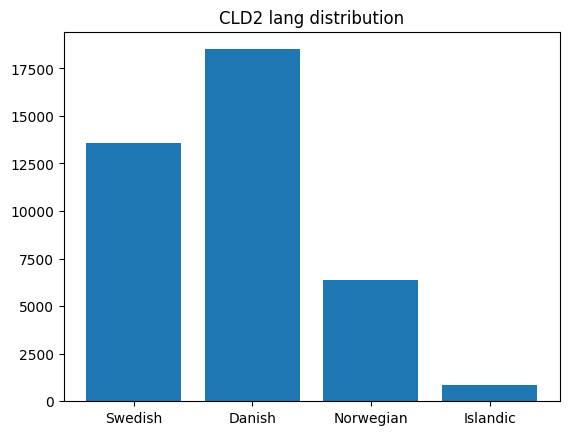

In [39]:
plt.bar(
    ["Swedish", "Danish", "Norwegian", "Islandic"],
    [sum(1 if lang in cld2_labels[i] else 0 for i in range(len(cld2_labels)))
      for lang in ["swe", "dan", "nor", "isl"]]
)
plt.title("CLD2 lang distribution")

Text(0.5, 1.0, 'FastText lang distribution')

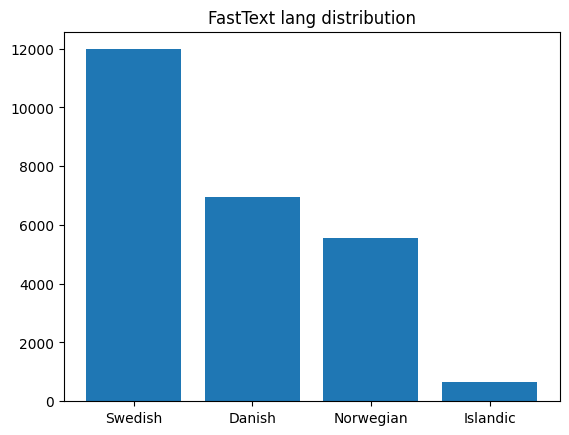

In [54]:
plt.bar(
    ["Swedish", "Danish", "Norwegian", "Islandic"],
    [sum(1 
         if fasttext_scores[i].get(lang, 0.0) > thres and \
          fasttext_scores[i][lang] == max(s for _, s in fasttext_scores[i].items()) 
         else 0 
         for i in range(len(cld2_labels)))
      for lang, thres in [("sv", 0.2), ("da", 0.2), ("no", 0.2), ("is", 0.2)]]
)
plt.title("FastText lang distribution")

In [49]:
# Sample 20 random examples from each language
def print_examples(lang, thres, n=20):
    i = 0
    j = 0
    while j < n:
        if fasttext_scores[i].get(lang, 0.0) > thres and \
            fasttext_scores[i][lang] == max(s for _, s in fasttext_scores[i].items()):
            
            print(fasttext_scores[i][lang])
            print(texts[i])
            print()
            j += 1
        i += 1

In [50]:
print_examples("sv", 0.2)

0.39
juli 04, 2011
Monday
√Ñgg och bacon, hallon/banansmoothie
Egg and bacon, raspberry/banana smoothie
Santogold - Lights Out
Upplagd av aswedishgal kl. 10:15
Skicka med e-postBlogThis!Dela p√• TwitterDela p√• FacebookDela p√• Pinterest
3 kommentarer:
Ivy sa...
You should open your own Breakfast-Diner. I would be your everyday-guest, even If I had to move away from germany for that :D
4 juli 2011 kl. 10:19
melwa sa...
mums mums mums!
4 juli 2011 kl. 11:06
aswedishgal sa...
Ivy: Hahaha! Good idea. :)
Melwa: :)
4 juli 2011 kl. 11:19
Skicka en kommentar
Senaste inl√§gg √Ñldre inl√§gg Startsida
Prenumerera p√•: Kommentarer till inl√§gget (Atom)
Om mig
Hej! Jag √§r ett stort fan av mat. Du √§ter p√• egen risk. V√§lkommen!
Mail
camilla (at) camillasundberg (punkt) net
Bloggarkiv
‚ñ∫ 2015 (62)
‚ñ∫ maj (1)
‚ñ∫ april (31)
‚ñ∫ mars (27)
‚ñ∫ februari (3)
‚ñ∫ 2014 (141)
‚ñ∫ december (13)
‚ñ∫ november (15)
‚ñ∫ oktober (46)
‚ñ∫ september (29)
‚ñ∫ augusti (31)
‚ñ∫ juli (7)
‚ñ∫ 2013 (3)
‚ñ∫ mars (1)


In [51]:
print_examples("da", 0.3)

0.8
tirsdag den 17. maj 2011
I was here too.....
Endelig kom jeg forbi GARN-ITURE en dag i √•bningstiden. Nu havde jeg l√¶st om den p√• div blogs, og man kan da ikke bo i K√∏benhavn, uden at have v√¶ret forbi, n√•r andre kommer helt fra √Örhus. Og naturligvis kom jeg ud med 11 n√∏gler til samlingen - men farven var lige min, og s√• til nedsat pris...
So I was here too......
Indsendt af 1000ideer kl. 20.56
Send med mailBlog om dette!Del via TwitterDel via FacebookDel p√• Pinterest
Ingen kommentarer:
Send en kommentar
Nyere indl√¶g √Üldre indl√¶g Start
Abonner p√•: Kommentarer til indl√¶gget (Atom)
Bes√∏g min hjemmeside med > 1000ideer
Popul√¶re indl√¶g
En weekend med en strikkemaskeine - kursus
S√• har jeg langt om l√¶nge pr√∏vet at strikke p√• strikkemaskine. Det er sv√¶rt i starten, men n√•r man f√∏rst f√•r kn√¶kket koden, er det faktisk r...
Fors√∏g med h√¶klede hjerter
Har fundet et par opskrifter p√• et h√¶klet hjerte p√• bloggen http://i-crochet.blogspot.com/ . Den ene opskrift er

In [52]:
print_examples("no", 0.3)

0.76
Hjem
Kort info om R√∏ros
Kommunev√•penet p√• R√∏ros
R√∏ros i gammel tid
Den eldste tiden
De f√∏rste menneskene
Malmer & mineraler
Malmforekomstene
Tektoniske forhold
Bergbrytingsmetoder
Fyrsetting
Sprengning
Om kobber
Circumferensen
Barokkparken i Hiort-Engan
Fredete hus og anlegg
UNESCO og verdensarven
Kobberverket Smelthytta og gruvene
R√∏ros Kobberverk
Tysk bergverkskunnskap
R√∏ros verk blir etablert
√òkonomiske interesser
De f√∏rste arbeiderne
Klagebrev til Christian V
Spell-Ola og rebellionen
L√∏nn og arbeidstid
Det frivillige bergkorps
Gruvedrifta
Nordgruvefeltet
Christianus Sextus
Kongens gruve
Muggruva
Storwartzfeltet
Gamle og Nye Storwartz gruve
Nyberget og Olavsgruva
Nyberget
Hestkletten
Olavsgruva
Andre gruver
Killingdal gruve
Hersj√∏gruva
Smelthytta
Kj√∏ring og materiale
Skiftordning og arbeidstid
Beskrivelse av hyttedriften
Kaldr√∏sting
R√•- eller Skj√¶rsteinssmelting
Vendr√∏sting og Svartkobbersmelting
Garring
De gamle smelteovnene
Belgene og kobberhammeren
Smelthytt

In [53]:
print_examples("is", 0.3)

0.37
BLACK FRIDAY
Herrar
√ç√ær√≥ttafatna√∞ur
N√ùTT Herra
Bolir
Buxur
Jakkar
N√¶rf√∂t
Peysur
Sokkar
Stuttbuxur
Sk√≥r
Blaksk√≥r
Golf Sk√≥r
Handboltask√≥r
Hlaupask√≥r
Utanvegask√≥r
√Üfingask√≥r
HOVR snjallhlaupask√≥r fr√° Under Armour
Fylgihlutir
Bakpokar
Br√∫sar
Hanskar
H√°rb√∂nd
H√∫fur
T√∂skur
Golf Herra
N√Ωtt Golf Herra
Buxur
Polo bolir
Peysur
Utanyfir fatna√∞ur
Golf Aukahlutir
Golf sk√≥r
D√∂mur
√≠√ær√≥ttaFatna√∞ur
N√ùTT D√∂mur
Bolir
Buxur
Jakkar
N√¶rf√∂t
Peysur
Sokkar
Stuttbuxur
St√¶rri st√¶r√∞ir
Toppar
Sk√≥r
Blaksk√≥r
Golf Sk√≥r
Handboltask√≥r
Hlaupask√≥r
Utanvegask√≥r
√Üfingask√≥r
HOVR snjallhlaupask√≥r fr√° Under Armour
Fylgihlutir
Bakpokar
Br√∫sar
Hanskar
H√°rb√∂nd
H√∫fur
T√∂skur
Golf D√∂mur
N√Ωtt Golf D√∂mur
Buxur
Polo bolir
Peysur
Utanyfir fatna√∞ur
Golf Aukahlutir
Golf sk√≥r
B√∂rn
√ç√ær√≥ttafatna√∞ur
N√ùTT Krakkar
Bolir
Buxur
Jakkar
Peysur
Sk√≥r
Fylgihlutir
Leikt√¶ki Barna
√Üfingav√∂rur
Boxv√∂rur
D√Ωnur/mottur
Endurheimt
Leikt√¶ki
L√≠til √¶fingat√¶ki
L√≥√∞/bj√∂llur
Nuddv√∂rur
S

From this, it seems like CLD2 predictions are OK for swe, isl and nor but quite bad for dan. Because of this, it is probably better to just do language detection ourselves using fasttext rather than relying on `WARC-Identified-Content-Language` metadata.